# Locust Prediction Modelling

Notes:

- `observation_date` is already encoded as `year`, `month`, `day`, separately
- The `dekad` variables are used for pseudo-absence generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv("../data/train_val_random.csv", index_col=0)
data_test = pd.read_csv("../data/test_random.csv", index_col=0)
data_train.head()

,date,lat_bucket_id,lon_bucket_id,Unnamed: 0.1,x,y,presence,year,month,day,...,SoilMoi0_10cm_inst_95,SoilMoi10_40cm_inst_95,SoilTMP0_10cm_inst_95,SoilTMP10_40cm_inst_95,Tveg_tavg_95,Wind_f_inst_95,Rainf_f_tavg_95,Tair_f_inst_95,Qair_f_inst_95,Psurf_f_inst_95
0,2000-01-11,442,658,1,-15.455833,20.581944,1,2000,1,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-29,461,676,2,-10.933333,25.383333,1,2000,1,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-04,437,655,3,-16.045278,19.471111,1,2000,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-02,435,660,4,-14.760833,18.966389,1,2000,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-17,442,658,5,-15.440278,20.643056,1,2000,1,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# assert len(data_train.drop(columns="presence").columns), len(data_test.columns)
missing_in_train = [n for n in data_test.columns if n not in data_train.columns]
missing_in_test = [n for n in data_train.columns if n not in data_test.columns]

print(f"Train missing {len(missing_in_train)} columns")
print(f"Test missing {len(missing_in_test)} columns")

data_test = data_test.drop(columns=missing_in_train)
data_train = data_train.drop(columns=missing_in_test)

Train missing 15 columns
Test missing 0 columns


In [4]:
cats = data_train.select_dtypes(np.integer).columns.tolist()
objects = data_train.select_dtypes(np.object).columns.tolist()
floats = data_train.select_dtypes(np.float).columns.tolist()
assert len(cats) + len(objects) + len(floats) == len(data_train.columns)

print("Objects:", objects)
print("Categoricals:", cats)
print("Floats:", floats[:10])

Objects: ['date', 'observation_date']
Categoricals: ['lat_bucket_id', 'lon_bucket_id', 'Unnamed: 0.1', 'presence', 'year', 'month', 'day']
Floats: ['x', 'y', 'SoilMoi0_10cm_inst_dekad1', 'SoilMoi0_10cm_inst_dekad2', 'SoilMoi0_10cm_inst_dekad3', 'clay_0.5cm_mean', 'clay_5.15cm_mean', 'sand_0.5cm_mean', 'sand_5.15cm_mean', 'silt_0.5cm_mean']


In [5]:
data_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16159 entries, 0 to 16158
Columns: 1172 entries, date to Psurf_f_inst_95
dtypes: float64(1163), int64(7), object(2)
memory usage: 144.6+ MB


In [6]:
# Check for NAN values
nans = data_train.isnull().sum()
# [(k,v,d) for k,v,d in zip(nans.keys(), nans.values, data_train.dtypes) if v>0]

In [7]:
# Fill NAN values with median
for col in data_train.columns:
    n_train_nans = pd.isnull(data_train[col]).sum()
    n_test_nans = pd.isnull(data_test[col]).sum()
    if data_train[col].dtype == np.float:
        m = data_train[col].median()
        if n_train_nans:
            data_train[col] = data_train[col].fillna(m)
        if n_test_nans:
            data_test[col] = data_test[col].fillna(m)
        
assert not data_train.isnull().sum().sum()
assert not data_test.isnull().sum().sum()

In [8]:
drops = ["observation_date", "date", "Unnamed: 0.1", "presence"]

def process_targets(data):
    target = data.presence.copy()
    data = data.drop(columns=drops)
    counts = list(zip(*np.unique(target, return_counts=True)))
    print("Counts:", counts)
    
    # merge pseudo-absence and true absence
    target.loc[target == 2] = 0
    return data, target

In [9]:
data_train, train_target = process_targets(data_train)
data_test, test_target = process_targets(data_test)

Counts: [(0, 8060), (1, 8086), (2, 13)]
Counts: [(0, 903), (1, 913)]


## Modelling

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [11]:
def evaluate(trues, preds):
    labels = ['absence', 'presence']
    results = {}
    results['accuracy'] = metrics.accuracy_score(trues, preds)
    results['confusion_matrix'] = metrics.confusion_matrix(trues, preds)
    results['kappa'] = metrics.cohen_kappa_score(trues, preds)
    results['f1'] = metrics.f1_score(trues, preds)
    
    print(metrics.classification_report(trues, preds, target_names=labels))
    return results

In [12]:
# Probably should split data sooner
seed = 111
train_x, val_x, train_y, val_y = train_test_split(
    data_train, train_target, test_size=0.2, random_state=seed)

## Logistic Regression

In [13]:
# Scale the dataset
scaler = preprocessing.MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)
test_x_scaled = scaler.transform(data_test)

In [14]:
model = LogisticRegression()
model.fit(train_x_scaled, train_y);

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
y_preds = model.predict(val_x_scaled)
logistic_val_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.92      0.84      0.88      1633
    presence       0.85      0.93      0.89      1599

    accuracy                           0.88      3232
   macro avg       0.89      0.88      0.88      3232
weighted avg       0.89      0.88      0.88      3232



In [16]:
y_preds = model.predict(test_x_scaled)
logistic_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.79      0.92      0.85       903
    presence       0.91      0.76      0.83       913

    accuracy                           0.84      1816
   macro avg       0.85      0.84      0.84      1816
weighted avg       0.85      0.84      0.84      1816



In [17]:
# Feature importance
weights = model.coef_[0].tolist()
features = list(zip(weights, data_train.columns))
list(sorted(features, key=lambda x: abs(x[0]), reverse=True))[:10]

[(-3.4399134108506852, 'lon_bucket_id'),
 (-3.4179008001962425, 'x'),
 (2.367783184280772, 'silt_0.5cm_mean'),
 (-2.3417928297516855, 'clay_0.5cm_mean'),
 (2.2481972688345975, 'silt_5.15cm_mean'),
 (-1.918868508286905, 'year'),
 (1.9047577431626894, 'sand_0.5cm_mean'),
 (1.5800484610807395, 'sand_5.15cm_mean'),
 (-1.540163935318407, 'clay_5.15cm_mean'),
 (-1.4229362385405269, 'y')]

### XGBoost

In [18]:
train_xgb = xgb.DMatrix(train_x, label=train_y)
val_xgb = xgb.DMatrix(val_x, label=val_y)
test_xgb = xgb.DMatrix(data_test)

In [19]:
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
model = xgb.train(params, train_xgb)
y_preds = model.predict(val_xgb).round(0)
xgb_val_results = evaluate(val_y, y_preds)

[14:10:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     absence       0.93      0.90      0.92      1633
    presence       0.90      0.93      0.92      1599

    accuracy                           0.92      3232
   macro avg       0.92      0.92      0.92      3232
weighted avg       0.92      0.92      0.92      3232



In [20]:
y_preds = model.predict(test_xgb).round(0)
xgb_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.96      0.90      0.93       903
    presence       0.91      0.96      0.93       913

    accuracy                           0.93      1816
   macro avg       0.93      0.93      0.93      1816
weighted avg       0.93      0.93      0.93      1816



#### Feature Importance

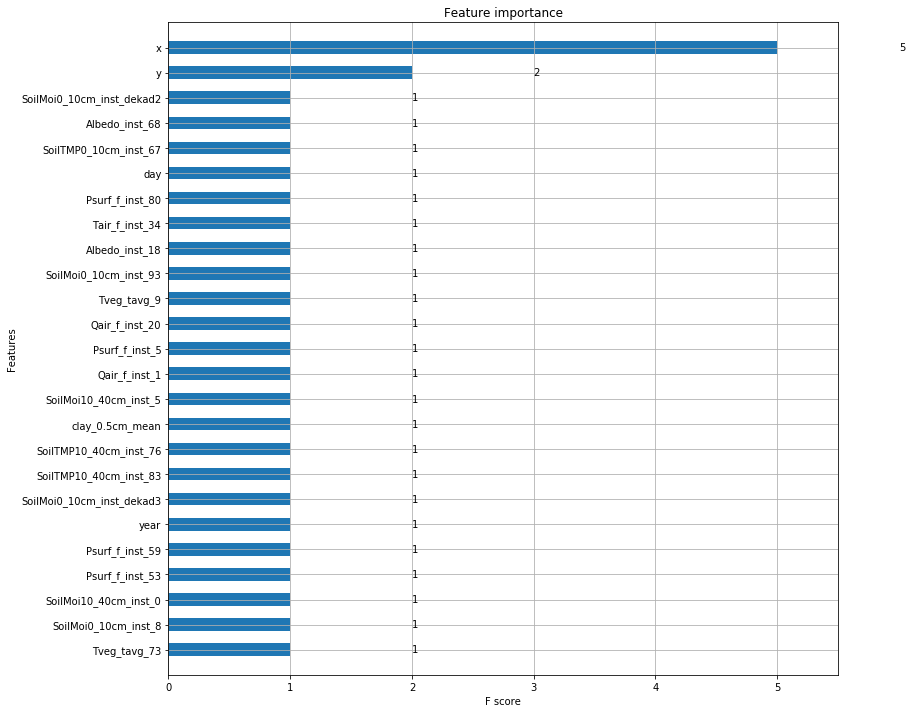

In [21]:
f,a = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.5, figure=f, ax=a);

### Random Forest

In [22]:
model = RandomForestClassifier()
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
y_preds = model.predict(val_x)
rf_val_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.97      0.95      0.96      1633
    presence       0.95      0.97      0.96      1599

    accuracy                           0.96      3232
   macro avg       0.96      0.96      0.96      3232
weighted avg       0.96      0.96      0.96      3232



In [24]:
y_preds = model.predict(data_test)
rf_test_results = evaluate(test_target, y_preds)

              precision    recall  f1-score   support

     absence       0.93      0.94      0.94       903
    presence       0.94      0.93      0.94       913

    accuracy                           0.94      1816
   macro avg       0.94      0.94      0.94      1816
weighted avg       0.94      0.94      0.94      1816



## Results

### Validation

In [25]:
val_results = pd.DataFrame({
    "Logistic": logistic_val_results, 
    "XGBoost": xgb_val_results, 
    "Random Forest": rf_val_results,
})
val_results

,Logistic,XGBoost,Random Forest
accuracy,0.882735,0.917389,0.957302
confusion_matrix,"[[1366, 267], [112, 1487]]","[[1470, 163], [104, 1495]]","[[1549, 84], [54, 1545]]"
kappa,0.765681,0.834822,0.914611
f1,0.886967,0.918023,0.957249


### Test

In [26]:
test_results = pd.DataFrame({
    "Logistic": logistic_test_results, 
    "XGBoost": xgb_test_results, 
    "Random Forest": rf_test_results,
})
test_results

,Logistic,XGBoost,Random Forest
accuracy,0.839758,0.930617,0.937225
confusion_matrix,"[[831, 72], [219, 694]]","[[813, 90], [36, 877]]","[[850, 53], [61, 852]]"
kappa,0.679791,0.861184,0.874452
f1,0.826683,0.932979,0.937294


## Interpretation